Train samples: 501808, test samples: 106895
train & test - done in 8s
split train & test - done in 0s
Starting LightGBM. Train shape: (501808, 123), test shape: (106895, 123)
Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.348026	train's l1: 0.297527	test's rmse: 0.351806	test's l1: 0.299871
[200]	train's rmse: 0.343994	train's l1: 0.294524	test's rmse: 0.35195	test's l1: 0.300443
Early stopping, best iteration is:
[1]	train's rmse: 0.352988	train's l1: 0.299447	test's rmse: 0.352114	test's l1: 0.297749
Fold  1 RMSE : 0.352114
Fold  1 MAE : 0.297749
Training until validation scores don't improve for 200 rounds
[100]	train's rmse: 0.347915	train's l1: 0.297414	test's rmse: 0.352881	test's l1: 0.301782
[200]	train's rmse: 0.34394	train's l1: 0.29443	test's rmse: 0.3531	test's l1: 0.302398
Early stopping, best iteration is:
[1]	train's rmse: 0.352892	train's l1: 0.299266	test's rmse: 0.352944	test's l1: 0.299529
Fold  2 RMSE : 0.352944
Fold  2 MAE : 0.2

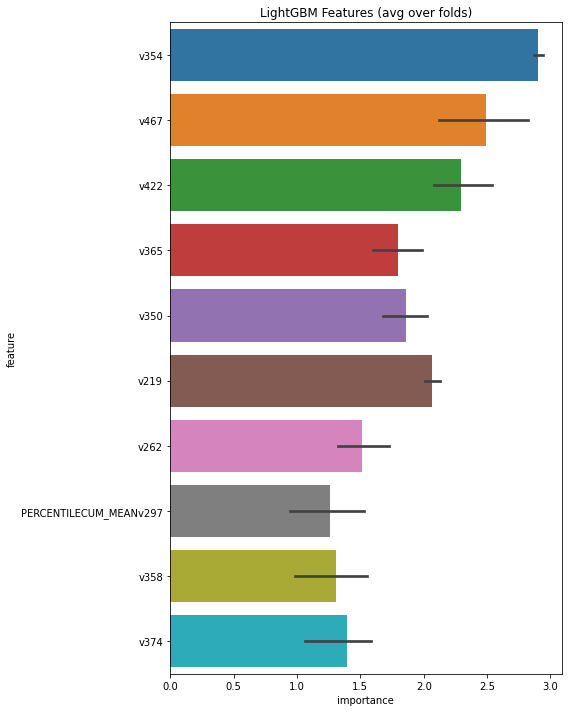

In [5]:
import gc
import re
import time
import warnings
from contextlib import contextmanager

import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from pandas.core.common import SettingWithCopyWarning
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold

warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=FutureWarning)

FEATS_EXCLUDED = ["ROW_ID", "target"]


def main(debug=False):
    num_rows = 10_000 if debug else None
    with timer("train & test"):
        df = train_test(num_rows)
    with timer("split train & test"):
        train_df = df[df["target"].notnull()]
        test_df = df[df["target"].isnull()]
        del df
        gc.collect()
    with timer("Run LightGBM with kfold"):
        kfold_lightgbm(train_df, test_df, num_folds=10, stratified=False, debug=debug)


@contextmanager
def timer(title):
    t0 = time.time()
    yield
    print(f"{title} - done in {time.time() - t0:.0f}s")


def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))


def mae(y_true, y_pred):
    return np.mean(abs(y_pred - y_true))


def train_test(num_rows=None):

    # load csv
    train_df = pd.read_csv(
        "../data/processed/fm_wo_collinear.csv", index_col=["ROW_ID"], nrows=num_rows,
    )
    test_df = pd.read_csv(
        "../data/processed/fm_test_wo_collinear.csv",
        index_col=["ROW_ID"],
        nrows=num_rows,
    )

    train_df = train_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
    test_df = test_df.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

    print(f"Train samples: {len(train_df)}, test samples: {len(test_df)}")

    # set target as nan
    test_df["target"] = np.nan

    # merge
    df = train_df.append(test_df)

    del train_df, test_df
    gc.collect()

    return df


# Display/plot feature importance
def display_importances(feature_importance_df_):
    cols = (
        feature_importance_df_[["feature", "importance"]]
        .groupby("feature")
        .mean()
        .sort_values(by="importance", ascending=False)[:10]
        .index
    )
    best_features = feature_importance_df_.loc[
        feature_importance_df_.feature.isin(cols)
    ]

    plt.figure(figsize=(8, 10))
    sns.barplot(
        x="importance",
        y="feature",
        data=best_features.sort_values(by="importance", ascending=False),
    )
    plt.title("LightGBM Features (avg over folds)")
    plt.tight_layout()
    plt.savefig("../reports/figures/lgbm_importances.png")


# LightGBM GBDT with KFold or Stratified KFold
def kfold_lightgbm(train_df, test_df, num_folds, stratified=False, debug=False):
    print(
        f"Starting LightGBM. Train shape: {train_df.shape}, test shape: {test_df.shape}"
    )

    # Cross validation model
    if stratified:
        folds = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)
    else:
        folds = KFold(n_splits=num_folds, shuffle=True, random_state=326)

    # Create arrays and dataframes to store results
    oof_preds = np.zeros(train_df.shape[0])
    sub_preds = np.zeros(test_df.shape[0])
    feature_importance_df = pd.DataFrame()
    feats = [f for f in train_df.columns if f not in FEATS_EXCLUDED]

    # k-fold
    for n_fold, (train_idx, valid_idx) in enumerate(
        folds.split(train_df[feats], train_df["target"])
    ):
        train_x, train_y = (
            train_df[feats].iloc[train_idx],
            train_df["target"].iloc[train_idx],
        )
        valid_x, valid_y = (
            train_df[feats].iloc[valid_idx],
            train_df["target"].iloc[valid_idx],
        )

        # set data structure
        lgb_train = lgb.Dataset(train_x, label=train_y, free_raw_data=False)
        lgb_test = lgb.Dataset(valid_x, label=valid_y, free_raw_data=False)

        # params optimized by hyperopt
        params = {
            "colsample_by_tree": 0.6982497601728399,
            "dart_subsample": 0.857376968999437,
            "is_unbalance": True,
            "learning_rate": 0.11417327493322736,
            "min_child_samples": 55,
            "num_leaves": 49,
            "reg_alpha": 0.30441558276373526,
            "reg_lambda": 0.5481580013447513,
            "subsample_for_bin": 20000,
            "metric": ["rmse", "mae"],
            "n_jobs": 16,
        }

        reg = lgb.train(
            params,
            lgb_train,
            valid_sets=[lgb_train, lgb_test],
            valid_names=["train", "test"],
            num_boost_round=10_000,
            early_stopping_rounds=200,
            verbose_eval=100,
        )

        oof_preds[valid_idx] = reg.predict(valid_x, num_iteration=reg.best_iteration)
        sub_preds += (
            reg.predict(test_df[feats], num_iteration=reg.best_iteration)
            / folds.n_splits
        )

        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = feats
        fold_importance_df["importance"] = np.log1p(
            reg.feature_importance(importance_type="gain", iteration=reg.best_iteration)
        )
        fold_importance_df["fold"] = n_fold + 1
        feature_importance_df = pd.concat(
            [feature_importance_df, fold_importance_df], axis=0
        )
        print(
            "Fold %2d RMSE : %.6f" % (n_fold + 1, rmse(valid_y, oof_preds[valid_idx]))
        )
        print("Fold %2d MAE : %.6f" % (n_fold + 1, mae(valid_y, oof_preds[valid_idx])))
        del reg, train_x, train_y, valid_x, valid_y
        gc.collect()

    # display importances
    display_importances(feature_importance_df)

    if not debug:
        # save submission file
        test_df.loc[:, "target"] = sub_preds
        test_df = test_df.reset_index()
        test_df[["ROW_ID", "target"]].to_csv(submission_file_name, index=False)


if __name__ == "__main__":
    submission_file_name = "../reports/submission.csv"
    with timer("Full model run"):
        main(debug=False)
